# Makemore Part 5: Wavenet
https://www.youtube.com/watch?v=t3YJ5hKiMQ0&ab_channel=AndrejKarpathy

In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from helpers import *

# Layer Classes 
---

In [5]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    

In [6]:
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [53]:
class WaveFlatten:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if self.out.shape[1] == 1:
            self.out = self.out .squeeze(1)
        return self.out

    def parameters(self):
        return []

In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weight = torch.rand((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [114]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # trained through backprop
        self.gamma = torch.ones(dim)
        self.bias = torch.zeros(dim)
        # trained through momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0 # dim to reduce over
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            # backprop
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / (xvar+self.eps)**0.5            
        self.out = self.gamma * xhat + self.bias
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.bias]

        

In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [148]:

class Sequential:
    
    def __init__(self, layers) -> None:
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    

___

In [116]:
torch.manual_seed(42)

In [160]:
words = open("names.txt").read().splitlines()
ctoi = char_to_int_map(start_char='.')
itoc = int_to_char_map(ctoi)
num_c = len(ctoi)
block_size = 8
X, Y = build_dataset(words, ctoi, block_size) 
vocab_size = len(ctoi)

In [162]:
import random
random.seed(42)
random.shuffle(words)

In [163]:
X_train, X_val, X_test  = split(X, [0.8,0.1,0.1])
Y_train, Y_val, Y_test = split(Y, [0.8,0.1,0.1])

In [164]:
n_embed = 24
n_hidden = 100

model = Sequential([
    Embedding(vocab_size, n_embed),
    WaveFlatten(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    WaveFlatten(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    WaveFlatten(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

for p in model.parameters():
    p.requires_grad = True

In [166]:
max_steps = 200000
batch_size = 32
lossi = []

for layer in model.layers:
    layer.training = True

for i in range(max_steps):
    
    # set batch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    X_batch, Y_batch = X_train[ix], Y_train[ix]
    
    # forward
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)
    
    # backward
    for p in model.parameters():
        p.grad = None # flush last gradients
    loss.backward() # calc new gradients
    
    lr = 0.1 if i < 150000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
        

      0/ 200000: 3.2943
  10000/ 200000: 2.5299
  20000/ 200000: 2.4283
  30000/ 200000: 1.9757
  40000/ 200000: 1.8556
  50000/ 200000: 1.7828
  60000/ 200000: 2.0849
  70000/ 200000: 1.8682
  80000/ 200000: 1.7687
  90000/ 200000: 1.9820
 100000/ 200000: 1.5623
 110000/ 200000: 2.1144
 120000/ 200000: 1.7434
 130000/ 200000: 1.9764
 140000/ 200000: 2.0296
 150000/ 200000: 1.9188
 160000/ 200000: 2.2857
 170000/ 200000: 1.7709
 180000/ 200000: 2.3311
 190000/ 200000: 1.7162


In [167]:
mean_lossi = torch.tensor(lossi).view(-1, 1000).mean(1)

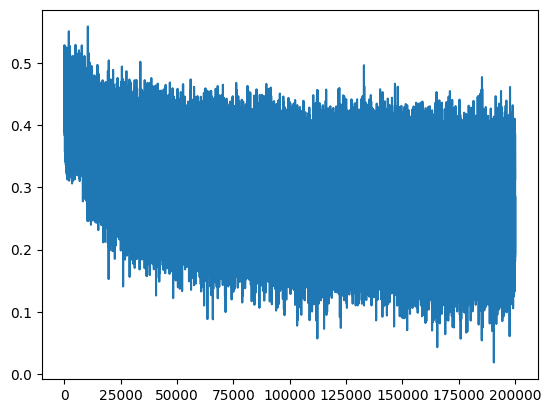

In [168]:
plt.plot(lossi)

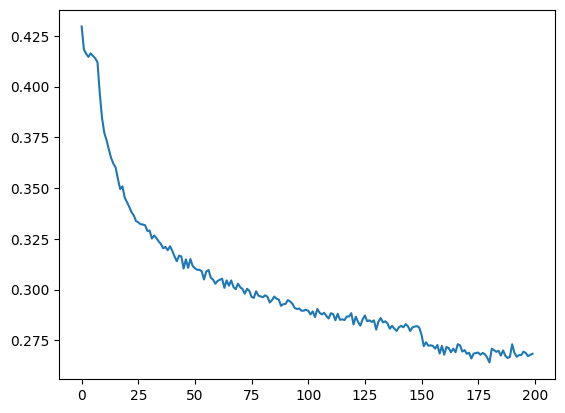

In [169]:
plt.plot(mean_lossi)

In [170]:
for layer in model.layers:
    layer.training = False

In [178]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.8391250371932983
val 2.2407846450805664


In [177]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      logits = model(torch.tensor([context])) # (1,block_size,d)      
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in out))

maxtyn.
elzie.
emelya.
davarnelle.
ayonna.
darlina.
custianna.
rockend.
andree.
saadi.
huntlea.
zaynn.
limatani.
amylah.
iciel.
dockleigh.
jailynnn.
brea.
mayva.
kenleigh.
